In [3]:
!pip install meteostat
from meteostat import Daily, Point
from datetime import datetime

nyc = Point(40.7128, -74.0060)
start = datetime(2023, 1, 1)
end = datetime(2023, 1, 7)

weather = Daily(nyc, start, end).fetch().reset_index()
weather.head()
import pandas as pd

# Load the uploaded CSV
retail_df = pd.read_csv("retail_sales_dataset.csv")

# Check what it looks like
retail_df.head()


,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


In [6]:
# Merge daily_sales (from your retail data) with weather (from Meteostat)
merged = pd.merge(daily_sales, weather, left_on='Date', right_on='time')

# Preview the merged dataset
merged.head()


,Date,total_sales,transaction_count,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2023-01-01,3600,3,2023-01-01,8.1,4.6,10.6,0.0,0.0,<NA>,9.4,<NA>,1013.5,<NA>
1,2023-01-02,1765,4,2023-01-02,7.5,4.2,12.3,1.3,0.0,<NA>,7.4,<NA>,1020.1,<NA>
2,2023-01-03,600,1,2023-01-03,10.2,7.9,13.6,11.4,0.0,<NA>,5.7,<NA>,1014.9,<NA>
3,2023-01-04,1240,3,2023-01-04,13.0,10.2,17.1,0.5,0.0,<NA>,10.4,<NA>,1010.8,<NA>
4,2023-01-05,1100,3,2023-01-05,10.9,7.9,13.7,0.0,0.0,<NA>,11.5,<NA>,1014.1,<NA>


In [5]:
# Convert 'Date' to datetime format
retail_df['Date'] = pd.to_datetime(retail_df['Date'])

# Group by date to get total daily sales and transaction count
daily_sales = retail_df.groupby('Date').agg(
    total_sales=('Total Amount', 'sum'),
    transaction_count=('Transaction ID', 'count')
).reset_index()

daily_sales.head()


,Date,total_sales,transaction_count
0,2023-01-01,3600,3
1,2023-01-02,1765,4
2,2023-01-03,600,1
3,2023-01-04,1240,3
4,2023-01-05,1100,3


In [7]:
# Add season column
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'

merged['season'] = merged['Date'].dt.month.map(get_season)

# Add flag for extreme temperature (below 0 or above 30°C)
merged['is_extreme_temp'] = (merged['tavg'] < 0) | (merged['tavg'] > 30)

# Add binary target: high sales (above median)
merged['high_sales'] = merged['total_sales'] > merged['total_sales'].median()

# Show updated dataset
merged.head()


,Date,total_sales,transaction_count,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,season,is_extreme_temp,high_sales
0,2023-01-01,3600,3,2023-01-01,8.1,4.6,10.6,0.0,0.0,<NA>,9.4,<NA>,1013.5,<NA>,winter,False,True
1,2023-01-02,1765,4,2023-01-02,7.5,4.2,12.3,1.3,0.0,<NA>,7.4,<NA>,1020.1,<NA>,winter,False,True
2,2023-01-03,600,1,2023-01-03,10.2,7.9,13.6,11.4,0.0,<NA>,5.7,<NA>,1014.9,<NA>,winter,False,False
3,2023-01-04,1240,3,2023-01-04,13.0,10.2,17.1,0.5,0.0,<NA>,10.4,<NA>,1010.8,<NA>,winter,False,True
4,2023-01-05,1100,3,2023-01-05,10.9,7.9,13.7,0.0,0.0,<NA>,11.5,<NA>,1014.1,<NA>,winter,False,False


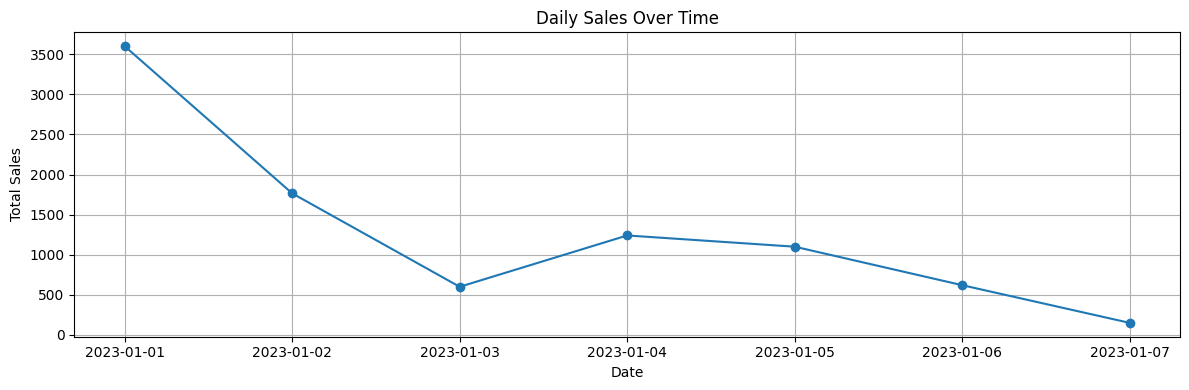

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot sales over time
plt.figure(figsize=(12, 4))
plt.plot(merged['Date'], merged['total_sales'], marker='o')
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()
plt.show()


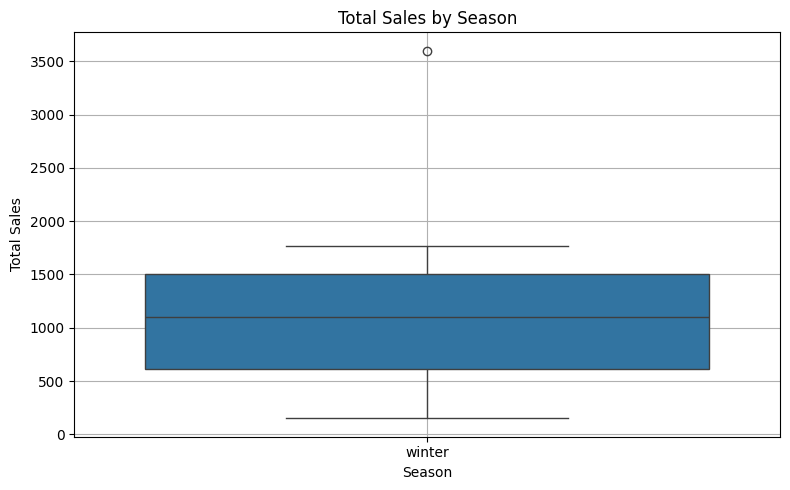

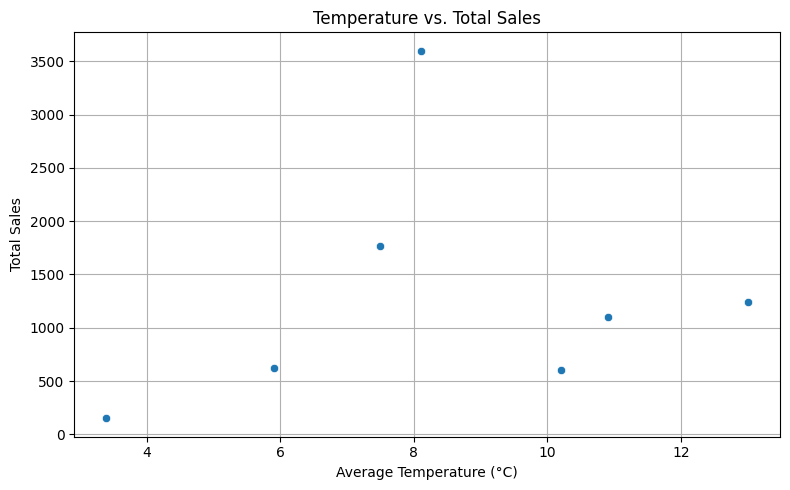

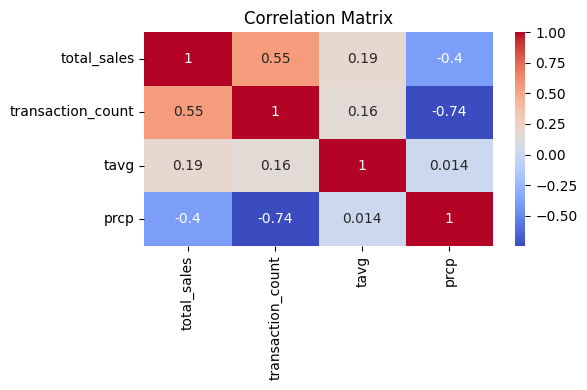

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Boxplot: Sales by season
plt.figure(figsize=(8, 5))
sns.boxplot(data=merged, x='season', y='total_sales')
plt.title('Total Sales by Season')
plt.xlabel('Season')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Scatter plot: Temperature vs. Total Sales
plt.figure(figsize=(8, 5))
sns.scatterplot(data=merged, x='tavg', y='total_sales')
plt.title('Temperature vs. Total Sales')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Correlation heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(
    merged[['total_sales', 'transaction_count', 'tavg', 'prcp']].corr(),
    annot=True,
    cmap='coolwarm'
)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


In [10]:
from scipy.stats import ttest_ind, f_oneway

# T-test: high vs. low sales based on temperature
high_temp = merged[merged['tavg'] > merged['tavg'].median()]['total_sales']
low_temp = merged[merged['tavg'] <= merged['tavg'].median()]['total_sales']

t_stat, p_val = ttest_ind(high_temp, low_temp)

print("T-test: High vs Low Temperature Days")
print(f"T-statistic: {t_stat:.2f}, P-value: {p_val:.4f}")

# ANOVA: test for differences in sales across seasons
groups = [group['total_sales'].values for name, group in merged.groupby('season')]
f_stat, p_anova = f_oneway(*groups)

print("\nANOVA: Sales Across Seasons")
print(f"F-statistic: {f_stat:.2f}, P-value: {p_anova:.4f}")


T-test: High vs Low Temperature Days
T-statistic: -0.60, P-value: 0.5746


TypeError: At least two samples are required; got 1.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Select features and target
features = ['tavg', 'prcp', 'season', 'is_extreme_temp']
target = 'high_sales'

X = merged[features]
y = merged[target]

# Categorical preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('season', OneHotEncoder(drop='first'), ['season'])  # encode 'season'
    ],
    remainder='passthrough'  # leave tavg, prcp, is_extreme_temp as they are
)

# Build pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
pipeline.fit(X_train, y_train)

# Predictions and evaluation
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", round(accuracy, 2))
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


Accuracy: 0.0

Confusion Matrix:
 [[0 0]
 [2 0]]

Classification Report:
               precision    recall  f1-score   support

       False       0.00      0.00      0.00       0.0
        True       0.00      0.00      0.00       2.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0



In [12]:
from meteostat import Daily, Point
from datetime import datetime

# New extended date range
start = datetime(2023, 1, 1)
end = datetime(2023, 3, 31)  # 3 months

# NYC coordinates
nyc = Point(40.7128, -74.0060)

# Fetch weather data
weather = Daily(nyc, start, end).fetch().reset_index()
weather.head()


,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2023-01-01,8.1,4.6,10.6,0.0,0.0,<NA>,9.4,<NA>,1013.5,<NA>
1,2023-01-02,7.5,4.2,12.3,1.3,0.0,<NA>,7.4,<NA>,1020.1,<NA>
2,2023-01-03,10.2,7.9,13.6,11.4,0.0,<NA>,5.7,<NA>,1014.9,<NA>
3,2023-01-04,13.0,10.2,17.1,0.5,0.0,<NA>,10.4,<NA>,1010.8,<NA>
4,2023-01-05,10.9,7.9,13.7,0.0,0.0,<NA>,11.5,<NA>,1014.1,<NA>


In [13]:
import numpy as np
import pandas as pd

# Use the 'weather' DataFrame as the base
sales_data = weather[['time', 'tavg', 'prcp']].copy()

# Rename 'time' to 'Date'
sales_data.rename(columns={'time': 'Date'}, inplace=True)

# Simulate total_sales based on temperature and precipitation
np.random.seed(42)

sales_data['base_sales'] = 1000 + (sales_data['tavg'] * 50) - (sales_data['prcp'] * 30)
sales_data['noise'] = np.random.normal(0, 200, size=len(sales_data))
sales_data['total_sales'] = (sales_data['base_sales'] + sales_data['noise']).clip(lower=200).round()

# Simulate transaction count as proportional to total_sales
sales_data['transaction_count'] = (sales_data['total_sales'] / 100).round().astype(int)

# Finalize retail_df
retail_df = sales_data[['Date', 'total_sales', 'transaction_count']].copy()
retail_df.head()


,Date,total_sales,transaction_count
0,2023-01-01,1504.0,15
1,2023-01-02,1308.0,13
2,2023-01-03,1298.0,13
3,2023-01-04,1940.0,19
4,2023-01-05,1498.0,15


In [14]:
# Merge retail and weather by Date
merged = pd.merge(retail_df, weather, left_on='Date', right_on='time')

# Add 'season'
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'

merged['season'] = merged['Date'].dt.month.map(get_season)

# Add extreme temperature flag
merged['is_extreme_temp'] = (merged['tavg'] < 0) | (merged['tavg'] > 30)

# Add high sales flag
merged['high_sales'] = merged['total_sales'] > merged['total_sales'].median()

# Check results
merged.head()


,Date,total_sales,transaction_count,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,season,is_extreme_temp,high_sales
0,2023-01-01,1504.0,15,2023-01-01,8.1,4.6,10.6,0.0,0.0,<NA>,9.4,<NA>,1013.5,<NA>,winter,False,True
1,2023-01-02,1308.0,13,2023-01-02,7.5,4.2,12.3,1.3,0.0,<NA>,7.4,<NA>,1020.1,<NA>,winter,False,True
2,2023-01-03,1298.0,13,2023-01-03,10.2,7.9,13.6,11.4,0.0,<NA>,5.7,<NA>,1014.9,<NA>,winter,False,True
3,2023-01-04,1940.0,19,2023-01-04,13.0,10.2,17.1,0.5,0.0,<NA>,10.4,<NA>,1010.8,<NA>,winter,False,True
4,2023-01-05,1498.0,15,2023-01-05,10.9,7.9,13.7,0.0,0.0,<NA>,11.5,<NA>,1014.1,<NA>,winter,False,True


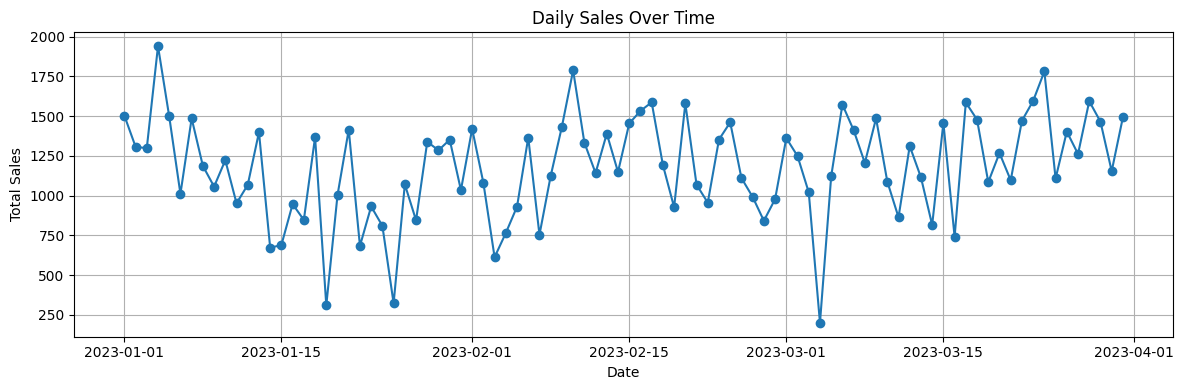

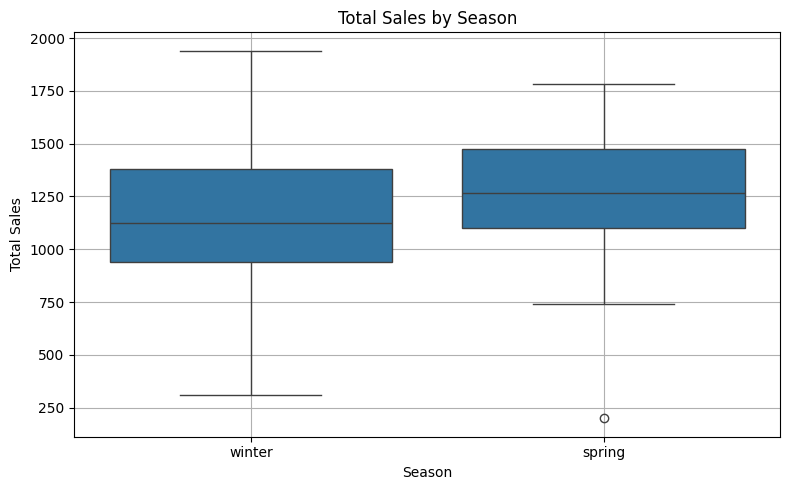

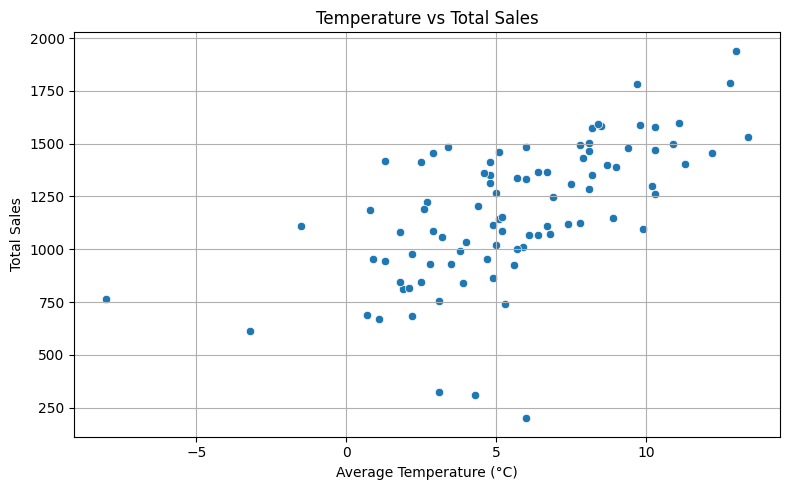

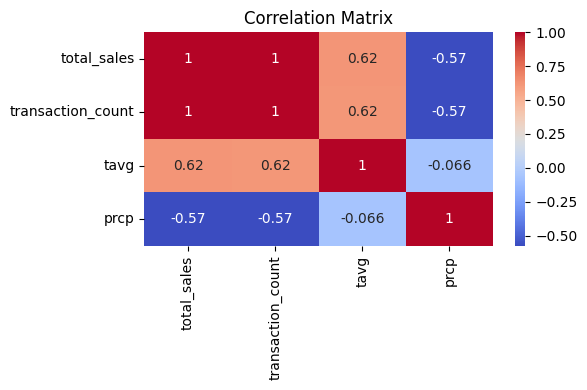

In [15]:
# NEW EDA CELL (paste as-is, runs everything together)
import matplotlib.pyplot as plt
import seaborn as sns

# Sales trend
plt.figure(figsize=(12, 4))
plt.plot(merged['Date'], merged['total_sales'], marker='o')
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

# Boxplot: Sales by Season
plt.figure(figsize=(8, 5))
sns.boxplot(data=merged, x='season', y='total_sales', order=['winter', 'spring'])
plt.title('Total Sales by Season')
plt.xlabel('Season')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter: Temperature vs Sales
plt.figure(figsize=(8, 5))
sns.scatterplot(data=merged, x='tavg', y='total_sales')
plt.title('Temperature vs Total Sales')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(
    merged[['total_sales', 'transaction_count', 'tavg', 'prcp']].corr(),
    annot=True,
    cmap='coolwarm'
)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


In [16]:
from scipy.stats import ttest_ind, f_oneway

# High vs low temp (median split)
high_temp = merged[merged['tavg'] > merged['tavg'].median()]['total_sales']
low_temp = merged[merged['tavg'] <= merged['tavg'].median()]['total_sales']
t_stat, p_val = ttest_ind(high_temp, low_temp)

print("T-test: High vs Low Temperature Days")
print(f"T-statistic: {t_stat:.2f}, P-value: {p_val:.4f}")

# ANOVA: Compare sales across seasons
groups = [group['total_sales'].values for _, group in merged.groupby('season')]
f_stat, p_anova = f_oneway(*groups)

print("\nANOVA: Sales Across Seasons")
print(f"F-statistic: {f_stat:.2f}, P-value: {p_anova:.4f}")


T-test: High vs Low Temperature Days
T-statistic: 4.99, P-value: 0.0000

ANOVA: Sales Across Seasons
F-statistic: 2.57, P-value: 0.1123


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Select features and target
features = ['tavg', 'prcp', 'season', 'is_extreme_temp']
target = 'high_sales'

X = merged[features]
y = merged[target]

# Encode 'season' and leave others as-is
preprocessor = ColumnTransformer(
    transformers=[
        ('season', OneHotEncoder(drop='first'), ['season'])  # one-hot encode 'season'
    ],
    remainder='passthrough'
)

# Build ML pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)

print("✅ Model Evaluation:")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 2))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


✅ Model Evaluation:
Accuracy: 0.72

Confusion Matrix:
 [[5 3]
 [2 8]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.71      0.62      0.67         8
         1.0       0.73      0.80      0.76        10

    accuracy                           0.72        18
   macro avg       0.72      0.71      0.71        18
weighted avg       0.72      0.72      0.72        18

